# **Proyecto Detector de Aprobación de Tarjetas de Crédito**

<p align="center">
  <img src="https://github.com/UrrutiaTs17/AI_Credit_Approval/blob/main/Banner_proyecto.jpg?raw=true" alt="Banner del proyecto" width="800">
</p>

- **Autores:**
  - Jose Alejandro Gómez Vargas - 2220077
  - William Andrés Urrutia Torres - 2220058


In [ ]:
#@title **Importación de librerías** { display-mode: "form" }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns

# Modelos de ML Supervisado
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC

#Modelos de ML no Supervisado
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE
sns.set_theme()
!pip install opendatasets
import opendatasets as od

# **Análisis y limpieza dataset:**

In [ ]:
#@title **Importación dataset desde Kaggle:**
# "username":"williamurrutia"
# "key":"6bc34c565bd28f9611717f617b1ac3a2"
dataset_link = "https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: williamurrutia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction


100%|██████████| 5.32M/5.32M [00:00<00:00, 844MB/s]

In [ ]:
#@title Importación csv
df = pd.read_csv("credit-card-approval-prediction/application_record.csv")
df_credit = pd.read_csv("credit-card-approval-prediction/credit_record.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
#@title Limpieza de **Application_Record**
df['YEARS_BIRTH'] = df['DAYS_BIRTH'].apply(lambda x: math.floor(abs(x) / 365))
df['OCCUPATION_TYPE'] = df['OCCUPATION_TYPE'].fillna('None')
df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].replace({'Y': 1, 'N': 0}).astype(int)
df[df['DAYS_EMPLOYED'] > 0] = 0
df['DAYS_EMPLOYED'] = df['DAYS_EMPLOYED'].abs()
columns = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
for column in columns:
  mapping = {
      income_type: index for index, income_type in enumerate(df[column].unique())
  }
  print(column,'= ' ,mapping, '\n')
  df[column] = df[column].map(mapping)

df.drop(['CODE_GENDER','DAYS_BIRTH','FLAG_MOBIL'], axis=1, inplace=True)

<ipython-input-4-ef8c066fff17>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].replace({'Y': 1, 'N': 0}).astype(int)


NAME_INCOME_TYPE =  {'Working': 0, 'Commercial associate': 1, 0: 2, 'State servant': 3, 'Student': 4, 'Pensioner': 5} 

NAME_EDUCATION_TYPE =  {'Higher education': 0, 'Secondary / secondary special': 1, 0: 2, 'Incomplete higher': 3, 'Lower secondary': 4, 'Academic degree': 5} 

NAME_FAMILY_STATUS =  {'Civil marriage': 0, 'Married': 1, 'Single / not married': 2, 0: 3, 'Separated': 4, 'Widow': 5} 

NAME_HOUSING_TYPE =  {'Rented apartment': 0, 'House / apartment': 1, 0: 2, 'Municipal apartment': 3, 'With parents': 4, 'Co-op apartment': 5, 'Office apartment': 6} 

OCCUPATION_TYPE =  {'None': 0, 'Security staff': 1, 'Sales staff': 2, 0: 3, 'Accountants': 4, 'Laborers': 5, 'Managers': 6, 'Drivers': 7, 'Core staff': 8, 'High skill tech staff': 9, 'Cleaning staff': 10, 'Private service staff': 11, 'Cooking staff': 12, 'Low-skill Laborers': 13, 'Medicine staff': 14, 'Secretaries': 15, 'Waiters/barmen staff': 16, 'HR staff': 17, 'Realty agents': 18, 'IT staff': 19} 



In [ ]:
#@title Limpieza de **Credit_Record**
df_credit['STATUS'] = df_credit['STATUS'].replace({'X': '0', 'C': '0'})
df_credit['STATUS'] = df_credit['STATUS'].astype(int)

## Elaboración de las Etiquetas usadas en los modelos de ML

In [ ]:
#@title **Diagnostico Application**
mean_income = df['AMT_INCOME_TOTAL'].mean()

def evaluar_aprobacion(row):
    puntaje = 0

    # Condición ingreso alto + educación superior o grado académico
    if row['AMT_INCOME_TOTAL'] > mean_income and row['NAME_EDUCATION_TYPE'] in [0, 4]:
        puntaje += 2

    # Condición estabilidad familiar
    if row['NAME_FAMILY_STATUS'] == 1 and row['CNT_CHILDREN'] <= 2:
        puntaje += 1

    # Condición estabilidad laboral reciente
    if row['DAYS_EMPLOYED'] > 365 and row['OCCUPATION_TYPE'] != 0:
        puntaje += 2

    # Condición propiedad combinada (auto + inmueble)
    if row['FLAG_OWN_CAR'] == 1 and row['FLAG_OWN_REALTY'] == 1:
        puntaje += 1

    # Edad productiva y vivienda estable
    if 25 <= row['YEARS_BIRTH'] <= 55 and row['NAME_HOUSING_TYPE'] == 1:
        puntaje += 1

    # Buen contacto (email y teléfono activos)
    if row['FLAG_EMAIL'] == 1 and row['FLAG_PHONE'] == 1:
        puntaje += 1

    # Aprobación final con 4 puntos o más
    return 1 if puntaje >= 4 else 0

# Aplicando la función al dataframe
df['DIAGNOSIS'] = df.apply(evaluar_aprobacion, axis=1)


In [ ]:
approved = df[df['DIAGNOSIS']==1]
rejected = df[df['DIAGNOSIS']==0]
print('Approved = ',(len(approved)/len(df))*100)
print('Rejected = ',(len(rejected)/len(df))*100)

Approved =  48.80825069489257
Rejected =  51.191749305107436


In [ ]:
def evaluar_credito(status):
    if status in [0,1,2]:
        return 1
    else:
        return 0
df_credit['Label_temp'] = df_credit['STATUS'].apply(evaluar_credito)
df_labels = df_credit.groupby('ID')['Label_temp'].min().reset_index()
df_labels.rename(columns={'Label_temp': 'Label'}, inplace=True)
df = pd.merge(df, df_labels, on='ID', how='left')
df['Label'] = df['Label'].fillna(df['DIAGNOSIS'])
df['Result'] = ((df['Label'] + df['DIAGNOSIS'])//2).astype(int)
df.drop(['DIAGNOSIS','Label'], axis=1, inplace=True)
df.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_EMPLOYED,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,YEARS_BIRTH,Result
0,5008804,1,1,0,427500.0,0,0,0,0,4542,1,0,0,0,2.0,32,0
1,5008805,1,1,0,427500.0,0,0,0,0,4542,1,0,0,0,2.0,32,0
2,5008806,1,1,0,112500.0,0,1,1,1,1134,0,0,0,1,2.0,58,1
3,5008808,0,1,0,270000.0,1,1,2,1,3051,0,1,1,2,1.0,52,1
4,5008809,0,1,0,270000.0,1,1,2,1,3051,0,1,1,2,1.0,52,1


In [ ]:
approved = df[df['Result']==1]
rejected = df[df['Result']==0]
print('Approved = ',(len(approved)/len(df))*100)
print('Rejected = ',(len(rejected)/len(df))*100)
print(len(approved))
print(len(rejected))

Approved =  48.77541573843309
Rejected =  51.22458426156691
213908
224649


# Importación dataset etiquetado:

In [ ]:
#@title **Importación dataset con etiquetas**
# "username":"williamurrutia"
# "key":"6bc34c565bd28f9611717f617b1ac3a2"
dataset_link = "https://www.kaggle.com/datasets/laotse/credit-card-approval"
od.download(dataset_link)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: williamurrutia
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/laotse/credit-card-approval


100%|██████████| 10.2M/10.2M [00:00<00:00, 946MB/s]

In [ ]:
#@title Importación csv { display-mode: "form" }
df_label = pd.read_csv("/content/credit-card-approval/credit_card_approval.csv")
df_label.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,JOB,BEGIN_MONTHS,STATUS,TARGET
0,5065438,F,Y,N,2+ children,270000.0,Secondary / secondary special,Married,With parents,-13258,-2300,1,0,0,0,Managers,-6,C,0
1,5142753,F,N,N,No children,81000.0,Secondary / secondary special,Single / not married,House / apartment,-17876,-377,1,1,1,0,Private service staff,-4,0,0
2,5111146,M,Y,Y,No children,270000.0,Higher education,Married,House / apartment,-19579,-1028,1,0,1,0,Laborers,0,C,0
3,5010310,F,Y,Y,1 children,112500.0,Secondary / secondary special,Married,House / apartment,-15109,-1956,1,0,0,0,Core staff,-3,0,0
4,5010835,M,Y,Y,2+ children,139500.0,Secondary / secondary special,Married,House / apartment,-17281,-5578,1,1,0,0,Drivers,-29,0,0


In [ ]:
#@title Limpieza del **Dataset Etiquetado**
df_label['YEARS_BIRTH'] = df_label['DAYS_BIRTH'].apply(lambda x: math.floor(abs(x) / 365))
#df_label['OCCUPATION_TYPE'] = df_label['OCCUPATION_TYPE'].fillna('None')
df_label[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = df_label[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].replace({'Y': 1, 'N': 0}).astype(int)
df_label['DAYS_EMPLOYED'] = df_label['DAYS_EMPLOYED'].abs()
df_label['CNT_CHILDREN'] = df_label['CNT_CHILDREN'].replace({
    '2+ children': 2,
    'No children': 0,
    '1 children': 1
}).astype(int)
columns = ['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE','JOB']
for column in columns:
  mapping = {
      income_type: index for index, income_type in enumerate(df_label[column].unique())
  }
  print(column,'= ' ,mapping, '\n')
  df_label[column] = df_label[column].map(mapping)
df_label['STATUS'] = df_label['STATUS'].replace({'X': '0', 'C': '0'})
df_label['STATUS'] = df_label['STATUS'].astype(int)
#IMPORTANTE las etiquetas estan alrevés, detectan personas riesgosas, no las que son aptas
df_label['TARGET'] = df_label['TARGET'].replace({0: 1, 1: 0})
target_column = df_label.pop('TARGET')
df_label['TARGET'] = target_column
df_label.drop(['CODE_GENDER','DAYS_BIRTH','BEGIN_MONTHS'], axis=1, inplace=True)

<ipython-input-12-315a8e46bbe5>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_label[['FLAG_OWN_CAR','FLAG_OWN_REALTY']] = df_label[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].replace({'Y': 1, 'N': 0}).astype(int)
<ipython-input-12-315a8e46bbe5>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_label['CNT_CHILDREN'] = df_label['CNT_CHILDREN'].replace({


NAME_EDUCATION_TYPE =  {'Secondary / secondary special': 0, 'Higher education': 1, 'Incomplete higher': 2, 'Lower secondary': 3, 'Academic degree': 4} 

NAME_FAMILY_STATUS =  {'Married': 0, 'Single / not married': 1, 'Civil marriage': 2, 'Separated': 3, 'Widow': 4} 

NAME_HOUSING_TYPE =  {'With parents': 0, 'House / apartment': 1, 'Rented apartment': 2, 'Municipal apartment': 3, 'Co-op apartment': 4, 'Office apartment': 5} 

JOB =  {'Managers': 0, 'Private service staff': 1, 'Laborers': 2, 'Core staff': 3, 'Drivers': 4, 'High skill tech staff': 5, 'Realty agents': 6, 'Secretaries': 7, 'Accountants': 8, 'Sales staff': 9, 'Medicine staff': 10, 'Waiters/barmen staff': 11, 'Low-skill Laborers': 12, 'Cleaning staff': 13, 'HR staff': 14, 'Cooking staff': 15, 'Security staff': 16, 'IT staff': 17} 



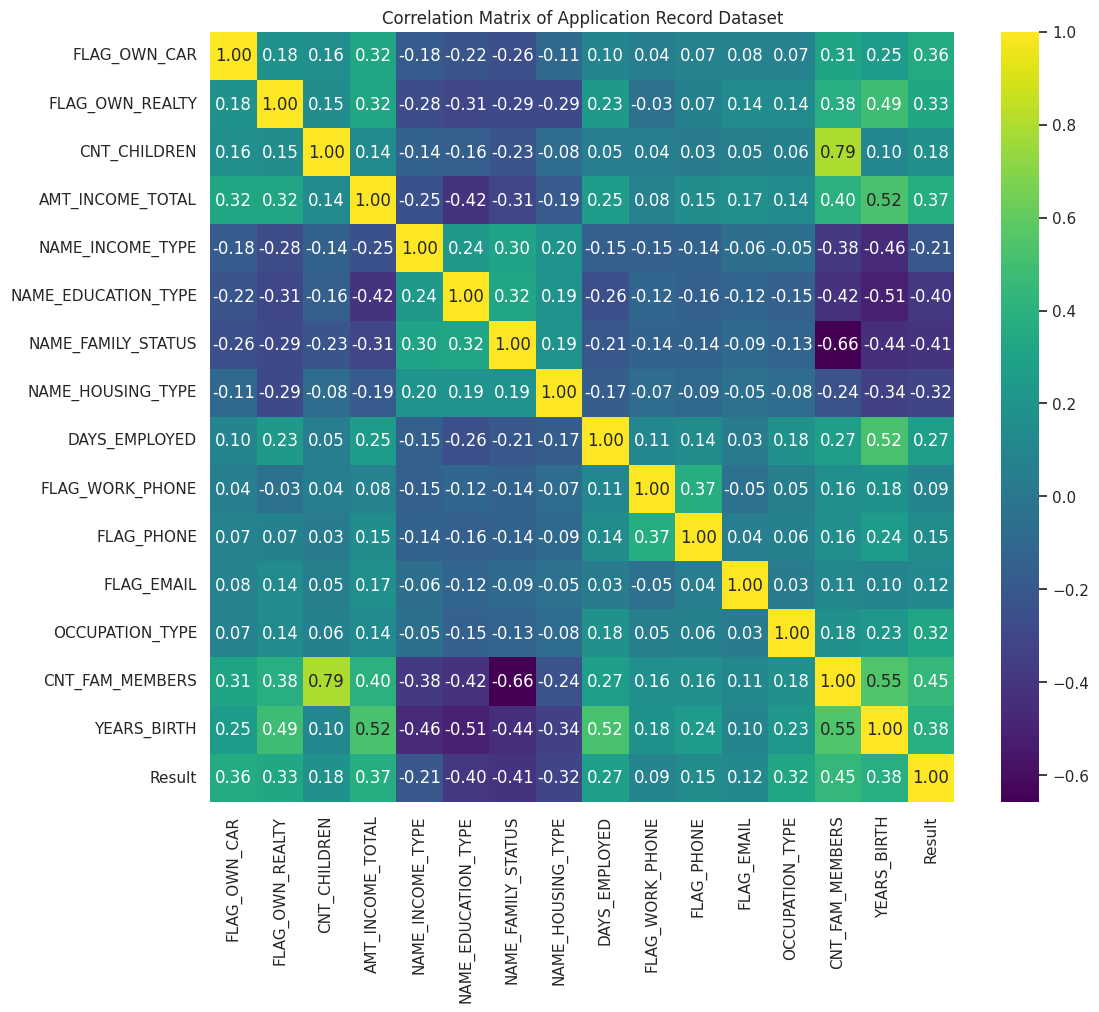

In [ ]:
#@title Matriz de correlación dataset
df_copy = df.copy()
df_copy.drop('ID', axis=1, inplace=True)
plt.figure(figsize=(12, 10))
sns.heatmap(df_copy.corr(), annot=True, cmap='viridis',fmt=".2f")
plt.title('Correlation Matrix of Application Record Dataset')
plt.show()

# **Primera entrega Análisis Dataset**☝

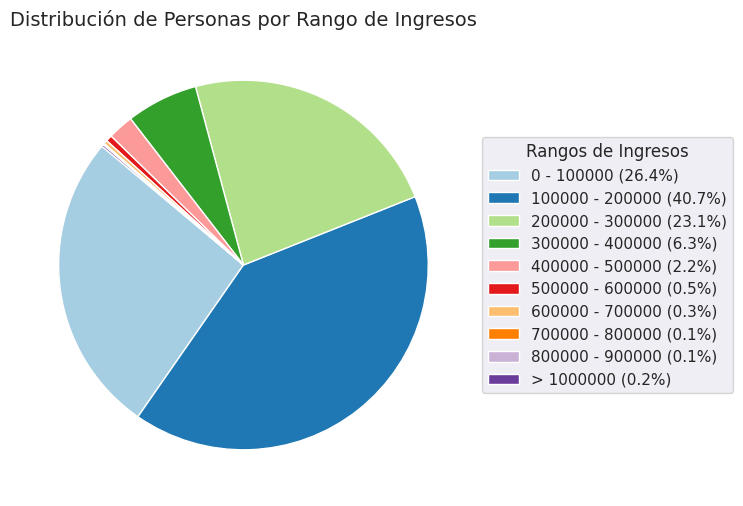

In [ ]:
#@title Distribución de personas según el ingreso

# Definir los rangos de 100,000 en 100,000 hasta 1,000,000
bins = np.arange(0, 1000000, 100000)
bins = np.append(bins, df['AMT_INCOME_TOTAL'].max() + 1)  # Última categoría para >1M

# Contar cuántas personas hay en cada rango
counts, _ = np.histogram(df['AMT_INCOME_TOTAL'], bins=bins)

# Definir etiquetas para cada rango
labels = [f'{int(bins[i])} - {int(bins[i+1])}' for i in range(len(bins)-2)]
labels.append(f'> 1000000')  # Último grupo

# Filtrar para no mostrar categorías con 0 personas
filtered_labels = [labels[i] for i in range(len(counts)) if counts[i] > 0]
filtered_counts = [counts[i] for i in range(len(counts)) if counts[i] > 0]

# Calcular los porcentajes de cada grupo
total = sum(filtered_counts)
percentages = [(count / total) * 100 for count in filtered_counts]

# Crear etiquetas con porcentaje para la leyenda
legend_labels = [f"{filtered_labels[i]} ({percentages[i]:.1f}%)" for i in range(len(filtered_labels))]

# Crear el diagrama de torta sin etiquetas en el gráfico
plt.figure(figsize=(10, 6))
wedges, _ = plt.pie(filtered_counts, startangle=140, colors=plt.cm.Paired.colors)

# Agregar una leyenda al lado con los porcentajes
plt.legend(wedges, legend_labels, title="Rangos de Ingresos", loc="center left", bbox_to_anchor=(1, 0.5))

# Título
plt.title('Distribución de Personas por Rango de Ingresos', fontsize=14)

# Mostrar gráfico
plt.show()


In [ ]:
#@title Distribución de la edad de las personas en el dataset
df['AGE_YEARS'] = abs(df['DAYS_BIRTH']) / 365  # Convertir días a años

plt.figure(figsize=(8,5))
sns.histplot(df['AGE_YEARS'], bins=30, kde=True, color='purple')
plt.title('Distribución de Edad')
plt.xlabel('Edad en años')
plt.ylabel('Frecuencia')
plt.show()


KeyError: 'DAYS_BIRTH'

In [ ]:
#@title Distribución de las personas según su nivel educativo alcanzado
# Contar la cantidad de personas en cada categoría de educación
education_counts = df['NAME_EDUCATION_TYPE'].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
ax = sns.barplot(x=education_counts.index, y=education_counts.values, palette="viridis")

# Agregar los valores encima de cada barra
for i, count in enumerate(education_counts.values):
    ax.text(i, count + 100, str(count), ha='center', fontsize=12, fontweight='bold')  # Se suma 100 para evitar que el texto toque la barra

# Agregar etiquetas y títulos
plt.xlabel("Nivel Educativo", fontsize=12)
plt.ylabel("Cantidad de Personas", fontsize=12)
plt.title("Distribución de Personas por Nivel Educativo", fontsize=14)

# Rotar etiquetas del eje X si son muchas categorías
plt.xticks(rotation=30, ha="right")

# Mostrar gráfico
plt.show()


In [ ]:
#@title Distribución de la cantidad de hijos de las personas
plt.figure(figsize=(8, 5))
child_counts = df['CNT_CHILDREN'].value_counts().sort_index()  # Ordenar por número de hijos
ax = sns.barplot(x=child_counts.index, y=child_counts.values, palette="coolwarm")

# Agregar valores encima de cada barra
for i, count in enumerate(child_counts.values):
    ax.text(i, count + 50, str(count), ha='center', fontsize=8, fontweight='bold')

plt.xlabel("Cantidad de Hijos", fontsize=12)
plt.ylabel("Número de Personas", fontsize=12)
plt.title("Distribución de la Cantidad de Hijos", fontsize=14)
plt.xticks(rotation=0)
plt.show()


In [ ]:
#@title Distribución de la cantidad Promedio de Hijos por Nivel de Educación
plt.figure(figsize=(8, 5))

# Calcular la media de hijos por nivel educativo
education_children = df.groupby('NAME_EDUCATION_TYPE')['CNT_CHILDREN'].mean().sort_values()

# Crear gráfico de barras
ax = sns.barplot(x=education_children.index, y=education_children.values, palette="magma")


plt.xlabel("Nivel de Educación", fontsize=12)
plt.ylabel("Promedio de Hijos", fontsize=12)
plt.title("Cantidad Promedio de Hijos por Nivel de Educación", fontsize=14)
plt.xticks(rotation=30, ha="right")
plt.show()


In [ ]:
#@title Distribución del ingreso promedio por Nivel de Educación
plt.figure(figsize=(8, 5))

# Calcular el ingreso promedio por nivel educativo
education_income = df.groupby('NAME_EDUCATION_TYPE')['AMT_INCOME_TOTAL'].mean().sort_values()

# Crear gráfico de barras
ax = sns.barplot(x=education_income.index, y=education_income.values, palette="coolwarm")

# Agregar valores encima de cada barra
for i, val in enumerate(education_income.values):
    ax.text(i, val + 1000, f"{val:,.0f}", ha='center', fontsize=12, fontweight='bold')

plt.xlabel("Nivel de Educación", fontsize=12)
plt.ylabel("Ingreso Promedio", fontsize=12)
plt.title("Ingreso Promedio por Nivel de Educación", fontsize=14)
plt.xticks(rotation=30, ha="right")

plt.show()


In [ ]:
#@title Cantidad de Personas por Estado Civil
plt.figure(figsize=(10, 5))

# Contar la cantidad de personas por estado civil
family_status_counts = df["NAME_FAMILY_STATUS"].value_counts()

# Crear gráfico de barras
sns.barplot(x=family_status_counts.index, y=family_status_counts.values, palette="pastel")

plt.xlabel("Estado Civil", fontsize=12)
plt.ylabel("Cantidad de Personas", fontsize=12)
plt.title("Cantidad de Personas por Estado Civil", fontsize=14)
plt.xticks(rotation=30, ha="right")  # Rotar etiquetas si son muchas

# Agregar valores encima de las barras
for i, value in enumerate(family_status_counts.values):
    plt.text(i, value + 50, str(value), ha="center", fontsize=10)

plt.show()


In [ ]:
#@title Top 10 Profesiones más Comunes y su Promedio de Ingresos
plt.figure(figsize=(12, 6))

# Contar las profesiones más comunes
top_10_professions = df["OCCUPATION_TYPE"].value_counts().nlargest(10).index

# Filtrar el dataframe para solo incluir esas profesiones
df_top_professions = df[df["OCCUPATION_TYPE"].isin(top_10_professions)]

# Calcular el promedio de ingresos por profesión
avg_income_by_profession = df_top_professions.groupby("OCCUPATION_TYPE")["AMT_INCOME_TOTAL"].mean().sort_values()

# Crear el gráfico de barras
sns.barplot(x=avg_income_by_profession.values, y=avg_income_by_profession.index, palette="coolwarm")

plt.xlabel("Promedio de Ingreso Total", fontsize=12)
plt.ylabel("Profesión", fontsize=12)
plt.title("Top 10 Profesiones más Comunes y su Promedio de Ingresos", fontsize=14)

# Agregar etiquetas con los valores de ingresos en cada barra
for i, value in enumerate(avg_income_by_profession.values):
    plt.text(value, i, f"${int(value):,}", va="center", fontsize=10)

plt.show()


# **Segunda entrega Aplicación de Modelos ML Supervisado**✅

In [ ]:
#@title Aplicación Gaussian Naive Bayes  { display-mode: "form" }
# División de características y etiquetas
X = df.values[:, 1:-1]
y = df.values[:, -1]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Aplica Standard Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo Gaussian Naive Bayes
gnb_trained = GaussianNB()
gnb_trained.fit(X_train_scaled, y_train)

# Predicciones
y_pred_train = gnb_trained.predict(X_train_scaled)
y_pred_test = gnb_trained.predict(X_test_scaled)

# Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Aproved', 'Aproved'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Aproved', 'Aproved'], zero_division=1))


In [ ]:
#@title **Análisis de distribución de las Features**
# Lista de los nombres de las columnas de features (no el target)
feature_names = df.columns[1:-1]

# Graficar la distribución de cada feature
plt.figure(figsize=(20, 15))  # Ajusta el tamaño si tienes muchos features
for i, feature in enumerate(feature_names):
    plt.subplot(4, 4, i + 1)  # Cambia 4x4 según el número de features
    sns.histplot(df[feature], kde=True, bins=30)
    plt.title(f'Distribución de {feature}')
plt.tight_layout()
plt.show()

In [ ]:
#@title Aplicación **Multinomial** Naive Bayes  { display-mode: "form" }

# División de características y etiquetas
X = df.values[:, 1:-1]
y = df.values[:, -1]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# Modelo Gaussian Naive Bayes
est = MultinomialNB()
est.fit(X_train, y_train)

# Predicciones
y_pred_train = est.predict(X_train)
y_pred_test = est.predict(X_test)

# Reportes
print("Reporte en el conjunto de ENTRENAMIENTO:\n")
print(classification_report(y_train, y_pred_train, target_names=['No Aproved', 'Aproved'], zero_division=1))

print("Reporte en el conjunto de TEST:\n")
print(classification_report(y_test, y_pred_test, target_names=['No Aproved', 'Aproved'], zero_division=1))


Reporte en el conjunto de ENTRENAMIENTO:

              precision    recall  f1-score   support

  No Aproved       0.60      0.75      0.67    112413
     Aproved       0.64      0.46      0.54    106865

    accuracy                           0.61    219278
   macro avg       0.62      0.61      0.60    219278
weighted avg       0.62      0.61      0.60    219278

Reporte en el conjunto de TEST:

              precision    recall  f1-score   support

  No Aproved       0.59      0.75      0.66    112236
     Aproved       0.64      0.46      0.54    107043

    accuracy                           0.61    219279
   macro avg       0.62      0.61      0.60    219279
weighted avg       0.62      0.61      0.60    219279



In [ ]:
#@title Aplicacion **Decision Tree** { display-mode: "form" }

X = df.values[:, 1:-1]
y = df.values[:, -1]

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


# 6. Entrenar el árbol de decisión
dt_trained = DecisionTreeClassifier( max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42)
dt_trained.fit(X_train, y_train)

# 7. Predecir y evaluar para entrenamiento
y_train_pred = dt_trained.predict(X_train)
print("Clasificación para el conjunto de entrenamiento:")
print(classification_report(y_train, y_train_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))

# 8. Predecir y evaluar para prueba
y_test_pred = dt_trained.predict(X_test)
print("\nClasificación para el conjunto de prueba:")
print(classification_report(y_test, y_test_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))


Clasificación para el conjunto de entrenamiento:
              precision    recall  f1-score   support

  No Aproved       0.98      0.99      0.98    112413
     Aproved       0.99      0.97      0.98    106865

    accuracy                           0.98    219278
   macro avg       0.98      0.98      0.98    219278
weighted avg       0.98      0.98      0.98    219278


Clasificación para el conjunto de prueba:
              precision    recall  f1-score   support

  No Aproved       0.98      0.99      0.98    112236
     Aproved       0.99      0.97      0.98    107043

    accuracy                           0.98    219279
   macro avg       0.98      0.98      0.98    219279
weighted avg       0.98      0.98      0.98    219279



In [ ]:
#@title **Validación Cruzada Decision Tree**

# Definimos el modelo con tus hiperparámetros exactos
model = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=10,
    min_samples_leaf=5,
    max_leaf_nodes=50,
    random_state=42
)

# Creamos métricas personalizadas para ambas clases
scoring = {
    'accuracy': 'accuracy',
    'precision_NoAproved': make_scorer(precision_score, pos_label=0),
    'recall_NoAproved': make_scorer(recall_score, pos_label=0),
    'precision_Aproved': make_scorer(precision_score, pos_label=1),
    'recall_Aproved': make_scorer(recall_score, pos_label=1),
    'f1_macro': 'f1_macro'
}

# Validación cruzada completa
cv_results = cross_validate(
    estimator=dt_trained,
    X=X,  # Usamos todos los datos
    y=y,
    cv=5,  # 5-fold estratificado
    scoring=scoring,
    return_train_score=True  # Para comparar con entrenamiento
)

# Resultados detallados
print("\n=== Resultados de Validación Cruzada ===")
print(f"Accuracy (Promedio CV): {cv_results['test_accuracy'].mean():.4f} ± {cv_results['test_accuracy'].std():.4f}")
print(f"\nPara 'No Aproved':")
print(f"Precision: {cv_results['test_precision_NoAproved'].mean():.4f} ± {cv_results['test_precision_NoAproved'].std():.4f}")
print(f"Recall: {cv_results['test_recall_NoAproved'].mean():.4f} ± {cv_results['test_recall_NoAproved'].std():.4f}")

print(f"\nPara 'Aproved':")
print(f"Precision: {cv_results['test_precision_Aproved'].mean():.4f} ± {cv_results['test_precision_Aproved'].std():.4f}")
print(f"Recall: {cv_results['test_recall_Aproved'].mean():.4f} ± {cv_results['test_recall_Aproved'].std():.4f}")

print(f"\nF1-Score (Macro): {cv_results['test_f1_macro'].mean():.4f} ± {cv_results['test_f1_macro'].std():.4f}")

# Comparación train vs test para detectar overfitting
print("\n=== Comparación Train vs Test ===")
print(f"Diff Accuracy (Train-Test): {cv_results['train_accuracy'].mean() - cv_results['test_accuracy'].mean():.4f}")
print(f"Diff F1-Score (Train-Test): {cv_results['train_f1_macro'].mean() - cv_results['test_f1_macro'].mean():.4f}")

In [ ]:
#@title Aplicación **Random Forest**  { display-mode: "form" }

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo
rf_trained = RandomForestClassifier( n_estimators=10,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42)


rf_trained.fit(X_train_scaled, y_train)

# Predicciones en train y test
y_train_pred = rf_trained.predict(X_train_scaled)
y_test_pred = rf_trained.predict(X_test_scaled)

print('Reporte en el conjunto de ENTRENAMIENTO:\n')
print(classification_report(y_train, y_train_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))

print('Reporte en el conjunto de TEST:\n')
print(classification_report(y_test, y_test_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))


In [ ]:
#@title **Validación Cruzada Random Forest**

# Definir métricas importantes para tu caso de negocio
scoring = {
    'accuracy': 'accuracy',
    'recall_NoAproved': make_scorer(recall_score, pos_label=0),  # Recall para clase 0
    'precision_Aproved': make_scorer(precision_score, pos_label=1),
    'f1_weighted': 'f1_weighted'
}

# Configurar el modelo con los mismos parámetros
model = RandomForestClassifier(
    n_estimators=10,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)

# Validación cruzada
cv_results = cross_validate(
    model,
    X_train,  # Usamos solo el conjunto de entrenamiento para validación
    y_train,
    cv=5,  # 5 folds estratificados
    scoring=scoring,
    return_train_score=True  # Para comparar train vs val
)

# Resultados promediados
print(f"Recall (No Aproved) - Validación: {cv_results['test_recall_NoAproved'].mean():.2f} ± {cv_results['test_recall_NoAproved'].std():.2f}")
print(f"Accuracy - Entrenamiento: {cv_results['train_accuracy'].mean():.2f}")
print(f"Accuracy - Validación: {cv_results['test_accuracy'].mean():.2f}")

In [ ]:
#@title Aplicación **SVC**  { display-mode: "form" }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=21)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Aumentar el peso relativo de "No Aproved"
svc = LinearSVC(
    class_weight={0: 1.5, 1: 1},  # 0 = "No Aproved", 1 = "Aproved"
    dual=False,
    random_state=21
)
svc.fit(X_train, y_train)

# Predicciones en train y test
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)

print('Reporte en el conjunto de ENTRENAMIENTO:\n')
print(classification_report(y_train, y_train_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))

print('Reporte en el conjunto de TEST:\n')
print(classification_report(y_test, y_test_pred, target_names=['No Aproved', 'Aproved'], zero_division=1))

In [ ]:
#@title Aplicación **Linear Regressor**

# División en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# 6. Entrenar el modelo de regresión lineal
model = LinearRegression()
model.fit(X_train, y_train)

# 7. Predecir y evaluar para entrenamiento
y_train_pred = model.predict(X_train)
print("Evaluación para el conjunto de entrenamiento:")
print(f"Mean Squared Error (MSE) para entrenamiento: {mean_squared_error(y_train, y_train_pred)}")
print(f"R² para entrenamiento: {r2_score(y_train, y_train_pred)}")

# 8. Predecir y evaluar para prueba
y_test_pred = model.predict(X_test)
print("\nEvaluación para el conjunto de prueba:")
print(f"Mean Squared Error (MSE) para prueba: {mean_squared_error(y_test, y_test_pred)}")
print(f"R² para prueba: {r2_score(y_test, y_test_pred)}")


# **Tercera Entrega Aplicación de Modelo de ML no Supervisado** ✅

In [ ]:
#@title **Aplicación del DBScan**

# Configuración para manejar datasets grandes
SAMPLE_SIZE = 20000  # Ajusta según la RAM disponible
np.random.seed(42)

# 1. Muestreo aleatorio si el dataset es muy grande
if len(df_label) > SAMPLE_SIZE:
    df_sample = df_label.sample(n=SAMPLE_SIZE, random_state=42)
else:
    df_sample = df_label.copy()


# 2. Preparación de datos optimizada
numeric_cols = [col for col in df_sample.select_dtypes(include=[np.number]).columns
               if col not in ['STATUS', 'TARGET', 'ID']]
df_numeric = df_sample[numeric_cols]


# 3. Escalado con menos memoria
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# 4. Determinación de parámetros (versión rápida)
neigh = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')  # Más eficiente
nbrs = neigh.fit(X_scaled)
distances, _ = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('Método del codo para determinar epsilon')
plt.axhline(y=2, color='r', linestyle='--')
plt.show()

# 5. DBSCAN con parámetros ajustados
db = DBSCAN(eps=2, min_samples=45, algorithm='ball_tree', n_jobs=-1)  # Usa todos los cores
labels = db.fit_predict(X_scaled)

# 6. Visualización con PCA (batch processing)
pca = PCA(n_components=5, svd_solver='randomized')  # Más rápido para grandes datasets
principal_components = pca.fit_transform(X_scaled)
plt.scatter(principal_components[:, 0], principal_components[:, 1],
            c=labels, cmap='viridis', alpha=0.6, s=10)
plt.colorbar()
plt.title('Clusters DBSCAN (muestra de {} puntos)'.format(SAMPLE_SIZE))
plt.show()
# Resultados
print("Resumen de clusters:")
print(pd.Series(labels).value_counts().sort_index())

In [ ]:
#@title Importancias de las features
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Crear DataFrame con la importancia de cada feature
feature_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'PC1_importance': loadings[:, 0],  # Contribución al primer componente
    'PC2_importance': loadings[:, 1]   # Contribución al segundo componente
})

# Ordenar por importancia absoluta en PC1 (el componente más relevante)
feature_importance['Abs_PC1_importance'] = np.abs(feature_importance['PC1_importance'])
top_features = feature_importance.sort_values('Abs_PC1_importance', ascending=False)

print("\nFeatures más relevantes para PC1:")
print(top_features[['Feature', 'PC1_importance']].head(10))

In [ ]:
#@title Cálculo de la varianza explicada por cada feature

total_var = pca.explained_variance_ratio_.sum() * 100
individual_var = np.abs(pca.components_).sum(axis=0) * pca.explained_variance_ratio_[:, np.newaxis]
individual_var = (individual_var.sum(axis=0) / individual_var.sum()) * total_var

# Crear gráfico
plt.figure(figsize=(12, 6))
bars = plt.barh(numeric_cols, individual_var, color='skyblue')
plt.xlabel('Porcentaje de Variación Explicada')
plt.title('Contribución de Cada Feature a la Varianza Total (PCA)')
plt.gca().invert_yaxis()  # Mostrar la feature más importante arriba

# Añadir etiquetas con los porcentajes
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.1f}%',
             ha='left', va='center')

plt.tight_layout()
plt.show()

## **Explicación:**
- Al principio lo que hacemos es filtrar el dataset ya que el DBScan es muy costoso computacionalmente con muchos datos como en nuetsro caso, tomamos un tamaño de muestra específico que permite que corra el DBScan.

- Seleccionamos nuestras columnas númericas.

- Escalamos los datos para que todas las variables tengan el mismo peso.

- Queremos encontrar un buen valor para el epsilon por lo que realizamos la prueba del codo,graficando la distancia al 5 vecino más cercano.

- Ajuste de los parametros minimo 5 puntos para un cluster, usamos el algoritmo ball_tree para la búsqueda eficiente de los vecinos.

- Y ponemos la CPU  a funcionar en paralelo con el n_jobs.

- Redujimos dimensionalidad para poder gráficar.

- Hacemos un conteo por cada cluster, el cluster de -1 son los outliers.

In [ ]:
#@title Aplicación del DBScan **tras aplicarse** PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Configuración
SAMPLE_SIZE = 20000
np.random.seed(42)

# 1. Muestreo aleatorio si el dataset es muy grande
if len(df_label) > SAMPLE_SIZE:
    df_sample = df_label.sample(n=SAMPLE_SIZE, random_state=42)
else:
    df_sample = df_label.copy()

# 2. Selección de columnas numéricas (excluye columnas irrelevantes)
numeric_cols = [col for col in df_sample.select_dtypes(include=[np.number]).columns
                if col not in ['STATUS', 'TARGET', 'ID']]
df_numeric = df_sample[numeric_cols]

# 3. Escalado de los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_numeric)

# 4. Reducción de dimensionalidad antes de clustering
# Cambiar n_components para que sea menor o igual al número de características (8)
pca = PCA(n_components=5, svd_solver='randomized')  # n_components ajustado
X_pca = pca.fit_transform(X_scaled)

# 5. Determinación de epsilon con método del codo en espacio reducido
neigh = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nbrs = neigh.fit(X_pca)
distances, _ = nbrs.kneighbors(X_pca)
distances = np.sort(distances[:, 4], axis=0)

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title('Método del codo para determinar epsilon (tras PCA)')
plt.axhline(y=0.6, color='r', linestyle='--')  # Puedes ajustar este valor
plt.show()

# 6. Aplicación de DBSCAN sobre los componentes principales
db = DBSCAN(eps=0.6, min_samples=45, algorithm='ball_tree', n_jobs=-1)
labels = db.fit_predict(X_pca)

# 7. Visualización (PCA a 2D solo para graficar)
# Es mejor transformar los datos escalados originales para la visualización
pca_vis = PCA(n_components=2)
X_vis = pca_vis.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='viridis', alpha=0.6, s=10)
plt.colorbar()
plt.title(f'Clusters DBSCAN tras PCA (muestra de {SAMPLE_SIZE} puntos)')
plt.show()

# 8. Resumen
print("Resumen de clusters:")
print(pd.Series(labels).value_counts().sort_index())